## Differential Drive Controller

Give the velocity V and the angular velocity $\omega$ from a twist message (we only consider linear.x and angular.x and ignore all other components) we can calculate the angular velocity of each wheel as follows:

We know
$$
\omega (R + b/2) = V_r
$$
$$
V_r = r\omega_r
$$
$$
V = R\omega
$$
where $\omega_r$ is the angular velocity of right wheel

Whith this we obtain
$$
\omega_r = \frac{V+\omega b/2}{r}
$$

and with
$$
\omega (R - b/2) = V_l
$$
we obtain
$$
\omega_l = \frac{V-\omega b/2}{r}
$$

### Converting ROS twist message to wheel speeds

The twist message uses m/s for linear velocity units and radians/s for the angular velocity units. We only consider the x component of the linear speed and the z component of the angular speed.

Assume $linerar_x$ in the range of -1 .. 1 and $angular_z$ in the range of -1 .. 1

$$
V = linerar_x
$$
$$
\omega = angular_z
$$

With this we obtain:
$$
\omega_r = \frac{linerar_x + angular_z b/2}{r}
$$
$$
\omega_l = \frac{linerar_x - angular_z b/2}{r}
$$


In [1]:
r = 0.0825
b = 2 * 0.18
# to get good values TODO needs review

In [2]:
def get_wheel_speed(msg):
    l_x = 10 * msg['linear']['x'] # -10 .. 10
    w = 55.* msg['angular']['z']  # -55 .. 55 
    w_r = (l_x + (b/2) * w) / r
    w_l = (l_x - (b/2) * w) / r
    return w_l, w_r

In [3]:
msg = {'linear': {'x': 1.0, 'y': 0.0, 'z': 0.0}, 'angular': {'x': 0.0, 'y': 0.0, 'z': 0.0}}
print(get_wheel_speed(msg))
msg = {'linear': {'x': 0.0, 'y': 0.0, 'z': 0.0}, 'angular': {'x': 0.0, 'y': 0.0, 'z': 1.0}}
print(get_wheel_speed(msg))
msg = {'linear': {'x': 1.0, 'y': 0.0, 'z': 0.0}, 'angular': {'x': 0.0, 'y': 0.0, 'z': 1.0}}
print(get_wheel_speed(msg))

(121.2121212121212, 121.2121212121212)
(-120.0, 120.0)
(1.2121212121212077, 241.2121212121212)


In [4]:
for i in range(11):
    for k in range(11):
        msg['linear']['x'] = i/10
        msg['angular']['z'] = k/10
        w_l, w_r = get_wheel_speed(msg)
        print("%.2f %.2f %s %s" % (i/10, k/10, int(w_l), int(w_r)))

0.00 0.00 0 0
0.00 0.10 -12 12
0.00 0.20 -24 24
0.00 0.30 -35 35
0.00 0.40 -48 48
0.00 0.50 -60 60
0.00 0.60 -71 71
0.00 0.70 -83 83
0.00 0.80 -96 96
0.00 0.90 -108 108
0.00 1.00 -120 120
0.10 0.00 12 12
0.10 0.10 0 24
0.10 0.20 -11 36
0.10 0.30 -23 48
0.10 0.40 -35 60
0.10 0.50 -47 72
0.10 0.60 -59 84
0.10 0.70 -71 96
0.10 0.80 -83 108
0.10 0.90 -95 120
0.10 1.00 -107 132
0.20 0.00 24 24
0.20 0.10 12 36
0.20 0.20 0 48
0.20 0.30 -11 60
0.20 0.40 -23 72
0.20 0.50 -35 84
0.20 0.60 -47 96
0.20 0.70 -59 108
0.20 0.80 -71 120
0.20 0.90 -83 132
0.20 1.00 -95 144
0.30 0.00 36 36
0.30 0.10 24 48
0.30 0.20 12 60
0.30 0.30 0 72
0.30 0.40 -11 84
0.30 0.50 -23 96
0.30 0.60 -35 108
0.30 0.70 -47 120
0.30 0.80 -59 132
0.30 0.90 -71 144
0.30 1.00 -83 156
0.40 0.00 48 48
0.40 0.10 36 60
0.40 0.20 24 72
0.40 0.30 12 84
0.40 0.40 0 96
0.40 0.50 -11 108
0.40 0.60 -23 120
0.40 0.70 -35 132
0.40 0.80 -47 144
0.40 0.90 -59 156
0.40 1.00 -71 168
0.50 0.00 60 60
0.50 0.10 48 72
0.50 0.20 36 84
0.50 0.30 24 96

### Converting Hoverboard Feedback to Odometry message

Reading $\omega_r$ and $\omega_l$ from the hoverboard we need to construct a odometry message. As a matter of fact we read the speed of each wheel but knowing the radius of the wheel we can calculate the angular speed of the wheel.

Using:

$$
\omega_r = \frac{linerar_x + angular_z b/2}{r}
$$
$$
\omega_l = \frac{linerar_x - angular_z b/2}{r}
$$

we obtain:
$$
linerar_x = \frac{r \cdot (\omega_r + \omega_l )}{2}
$$
$$
angular_z = \frac{r \cdot (\omega_r - \omega_l )}{b}
$$


As a next step we have to calculate the position and orientation at time $\Delta$t given the position and orientation at time t.

$$
x(t_0) = 0
$$
$$
y(t_0) = 0
$$
$$
\Theta(t_0) = 0
$$
$$
t_{n+1} = t_n + \Delta t
$$
$$
x(t_{n+1}) = x(t_n) + h(v_l(t_n) + v_r(t_n))cos(\Theta(t)
$$
$$
y(t_{n+1}) = y(t_n) + h(v_l(t_n) + v_r(t_n))sin(\Theta(t)
$$
$$
\Theta(t_{n+1}) =\Theta(t_n) + h(v_r(t) - v_l(t)
$$
where $h = t_{n+1} - t_n$


And to calculate a quaternion from $\Theta$:

$$
q_w = cos(\Theta/2)
$$
$$
q_z = 0
$$
$$q_y = 0
$$
$$q_z = sin(\Theta/2)
$$



In [5]:
import numpy as np
import quaternion

In [6]:
def get_pose(x0, y0, Theta0, v_r, v_l, delta_t):
    Theta1 = Theta0 + delta_t * (v_r - v_l)
    x1 = x0 + delta_t * (v_r + v_l) * np.cos(Theta1/2)
    y1 = y0 + delta_t * (v_r + v_l) * np.sin(Theta1/2)
    q1 = np.quaternion(np.cos(Theta1/2), 0, 0, np.sin(Theta1/2))
    return x1, y1, Theta1, q1

In [7]:
delta_t = 1/20
v_r = 1.
v_l = -1.
x_n = 0.
y_n = 0.
Theta_n = 0.
for i in range(10):
    x_n, y_n, Theta_n, q = get_pose(x_n, y_n, Theta_n, v_r, v_l, delta_t)
    print("x: %.2f y: %.2f q: %s" % (x_n, y_n, q))

x: 0.00 y: 0.00 q: quaternion(0.998750260394966, 0, 0, 0.0499791692706783)
x: 0.00 y: 0.00 q: quaternion(0.995004165278026, 0, 0, 0.0998334166468282)
x: 0.00 y: 0.00 q: quaternion(0.988771077936042, 0, 0, 0.149438132473599)
x: 0.00 y: 0.00 q: quaternion(0.980066577841242, 0, 0, 0.198669330795061)
x: 0.00 y: 0.00 q: quaternion(0.968912421710645, 0, 0, 0.247403959254523)
x: 0.00 y: 0.00 q: quaternion(0.955336489125606, 0, 0, 0.29552020666134)
x: 0.00 y: 0.00 q: quaternion(0.939372712847379, 0, 0, 0.342897807455451)
x: 0.00 y: 0.00 q: quaternion(0.921060994002885, 0, 0, 0.38941834230865)
x: 0.00 y: 0.00 q: quaternion(0.900447102352677, 0, 0, 0.43496553411123)
x: 0.00 y: 0.00 q: quaternion(0.877582561890373, 0, 0, 0.479425538604203)


# Applying Limits

We receive velocity (linear and angular), the time derivate of velocity is acceleration and the time derivate of acceleration is called jerk or jolt. To provide for a smooth movement of the robot we must apply limits to the velocity and the acceleration. At any time t the following contraints apply:

$$
v_{min} \le v(t) \le v_{max}
$$
$$
a_{min} \le \dot{v}(t) \le a_{max}
$$
$$
j_{min} \le \ddot{v}(t) \le j_{max}
$$

To solve $\ddot{v}$ numerically we need three data point $v_n$, $v_{n-1}$ and $v_{n-2}$

In [8]:
v_limit = 1.0
a_limit = 5.0
j_limit = 100.0
v_min = -v_limit
v_max = v_limit
a_min = -a_limit
a_max = a_limit
j_min = -j_limit
j_max = j_limit

In [9]:
def speed_limit(v_n, v_n1,v_n2, dt):
    a1 = (v_n - v_n1) / dt
    a2 = (v_n1 - v_n2) / dt
    a1 = min(a1, a_max)
    a2 = min(a2, a_max)
    a1 = max(a1, a_min)
    a2 = max(a2, a_min)
    j = (a1 - a2) / dt
    j = min(j, j_max)
    j = max(j, j_min)
    v = 2 * v_n1 - v_n2 + j * dt**2
    v = min(v, v_max)
    v = max(v, v_min)
    return v

In [10]:
dt = 1/20
t_max = 30
x = np.arange(0, t_max, dt)
v = np.zeros_like(x)
v[10] = 0.5
v[11] = 1.0
v[12] = 1.5
v[13] = 2.0
v[14:74] = 2.0
v[75:135] = -1.0
v[180:240] = -1.0
v[300:360] = 1.0

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

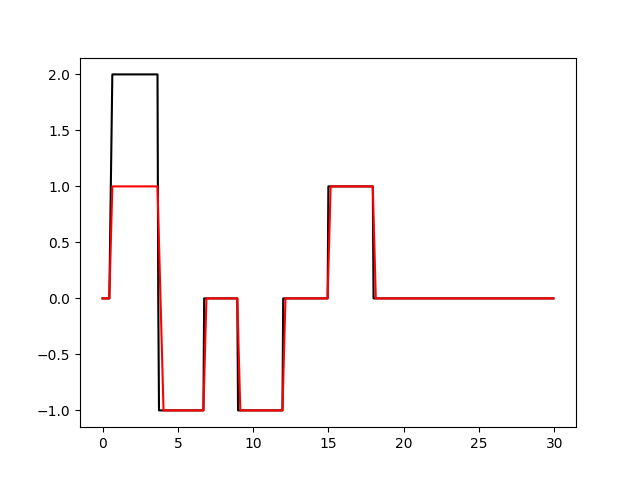

In [12]:
v_lim = [v[0], v[1]]
a = [0]
j = [0]
for i in range(len(v)-2):
    v_lim.append(speed_limit(v[i+2], v_lim[i+1], v_lim[i], 1/20))
for i in range(len(v)-1):
    a.append(v_lim[i+1]-v_lim[i])
for i in range(len(v)-1):
    j.append(a[i+1]-a[i])
fig, ax = plt.subplots()
ax.plot(x, v, 'k')
ax.plot(x, v_lim, 'r')
#ax.plot(x, a, 'g')
#ax.plot(x, j, 'b')

## PID Controller

In a closed loop system the controller will use the the output to adapt the input

![pid_controller](PID_controller.png)
$$source: \href{https://en.wikipedia.org/wiki/PID_controller}{wikipedia}$$

Error
-----
Control Systems try to reduce **error** in a system. It measures of how far away the **current state** is from the **desired state.**
 
PID
---
$$ PID_{response} = K_{p}*E + K_{i}\int_{0}^{t} E*dt + K_{d}dE$$

Horo
----

We model a single motor as a device that receives an input between -100 and 100 and returns an output between -100 and 100. We also assume that the acceleration of the motor is limited. We will provide a model that allows to simulate errors in the output

In [13]:
import random
class Process(object):
    def __init__(self, dt, acc_limit=1.0, noise=False):
        self.last_pos = 0
        self.noise = noise
        self.dt = dt
        self.acc_limit = acc_limit
        self.vel_limit = 1000
        self.hole = 50

    def update(self, new_pos):
        acc = (new_pos - self.last_pos) / self.dt
        acc = max(acc, -self.acc_limit)
        acc = min(acc, self.acc_limit)
        pos = self.last_pos + acc * dt
        if self.noise:
            if bool(random.getrandbits(1)):
                pos += 0.025 * pos * random.random()
            else:
                pos -= 0.025 * pos * random.random()
        pos = max(pos, -self.vel_limit)
        pos = min(pos, self.vel_limit)
        self.last_pos = pos
        # hoverboard gen2 sets speed to zero for any value between -50 and 50
        if pos > -self.hole and pos < self.hole:
            pos = 0
        return pos

In [14]:
class Controller(object):
    def __init__(self, Kp, Ki, Kd, dt):
        self.dt = dt
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.Kp_part = 0.
        self.Ki_part = 0.
        self.Kd_part = 0.
        self.prev_error = 0
        self.prev_errors_sum = 0
        
    def update(self, error):
        d_error = error - self.prev_error
        self.Kp_part = self.Kp * error
        self.Ki_part = self.Ki * (self.prev_errors_sum + error) * dt
        self.Kd_part = self.Kd * d_error / dt
        controller_return = self.Kp_part + self.Ki_part + self.Kd_part
        self.prev_errors_sum  = self.prev_errors_sum  + error
        return controller_return

In [15]:
dt = 1/20
t_max = 30
x = np.arange(0, t_max, dt)
v_desired = np.zeros_like(x)
v_desired[10] = 25.0
v_desired[11] = 50.0
v_desired[12] = 75.0
v_desired[13:74] = 100.0
v_desired[75:135] = -100.0
v_desired[180:240] = -100.0
v_desired[300:360] = 100.0
v_desired[420:480] = 150.0

v_desired[0:600] = 100.0

In [16]:
# for debugging
proc = Process(dt, acc_limit=900.)
ct = Controller(0.5, 0.0, .0, dt)
error = 0
desired_pos = 100
for i in range(5):
    cr = ct.update(error)
    if desired_pos > 0:
        set_pos = min(50, desired_pos - cr)
    set_pos = desired_pos - cr
    pos_set = proc.update(set_pos)
    print("%.2f %.2f %.2f %.2f %.2f" % (error, desired_pos, set_pos, pos_set, desired_pos - pos_set))
    error = desired_pos - pos_set

0.00 100.00 100.00 0.00 100.00
100.00 100.00 50.00 50.00 50.00
50.00 100.00 75.00 75.00 25.00
25.00 100.00 87.50 87.50 12.50
12.50 100.00 93.75 93.75 6.25


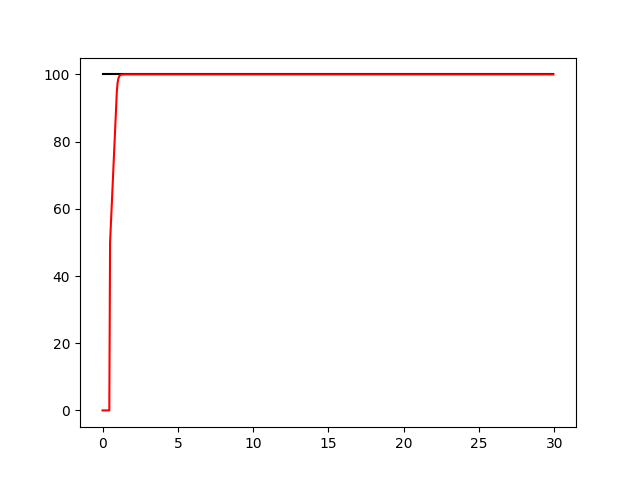

In [17]:
proc = Process(dt, acc_limit=100.)
v_set = np.zeros_like(x)
error = np.zeros_like(x)
cr = np.zeros_like(x)
ct = Controller(0.5, 0.0, .0, dt)
for i in range(1, len(v_desired)):
    cr[i] = ct.update(error[i-1])
    #print("%.2f %.2f %.2f %.2f" % (error[i-1], ct.Kp_part, ct.Ki_part, ct.Kd_part))
    # +/- has an impact! Use - to align with library below
    set_pos = v_desired[i-1] - cr[i]
    set_pos_save = set_pos
    if v_desired[i-1] >= 50. and set_pos >= 0. and set_pos < 50.:
        set_pos = 50
    if v_desired[i-1] <= -50. and set_pos <= 0. and set_pos > -50.:
        set_pos = -50
    #print("%.2f %.2f %.2f" % (set_pos_save, set_pos, v_desired[i-1]))
    v_set[i] = proc.update(set_pos)
    #print("%.2f %.2f %.2f" % (error[i-1], cr[i], v_set[i]))
    error[i] = v_desired[i] - v_set[i]
fig, ax = plt.subplots()
ax.plot(x, v_desired, 'k')
ax.plot(x, v_set, 'r')
#ax.plot(x, error, 'b')
#ax.plot(x, cr, 'g')

### Using a library

We will test the Python library simple-pid

In [18]:
import simple_pid

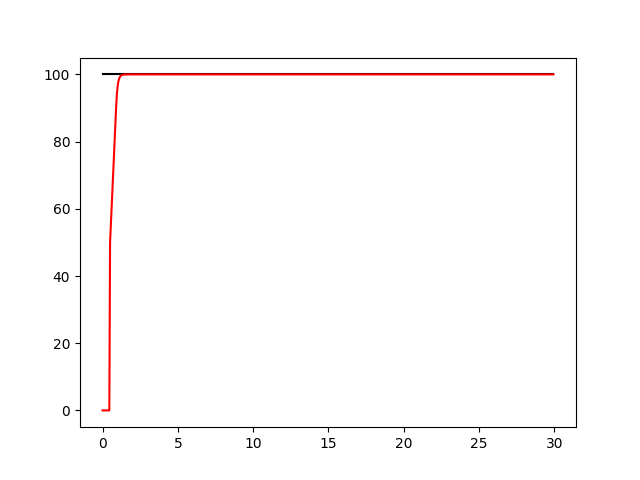

In [19]:
proc = Process(dt, acc_limit=100.)
v_set = np.zeros_like(x)
error = np.zeros_like(x)
cr = np.zeros_like(x)
ct = simple_pid.PID(Kp=0.6, Ki=0.0, Kd=.0, sample_time=None)
for i in range(1, len(v_desired)):
    cr[i] = ct(error[i-1])
    #print("%.2f %.2f %.2f %.2f" % (error[i-1], list(ct.components)[0], list(ct.components)[1], list(ct.components)[2]))
    set_pos = v_desired[i-1] + cr[i]
    set_pos_save = set_pos
    if v_desired[i-1] >= 50. and set_pos >= 0. and set_pos < 50.:
        set_pos = 50.
    if v_desired[i-1] <= -50. and set_pos <= 0. and set_pos > -50.:
        set_pos = -50
    #print("%.2f %.2f %.2f" % (set_pos_save, set_pos, v_desired[i-1]))
    v_set[i] = proc.update(set_pos)
    #print("%.2f %.2f %.2f" % (error[i-1], cr[i], v_set[i]))
    error[i] = v_desired[i] - v_set[i]
fig, ax = plt.subplots()
ax.plot(x, v_desired, 'k')
ax.plot(x, v_set, 'r')
#ax.plot(x, error, 'b')
#ax.plot(x, cr, 'g')

### Simulte noise in feedback

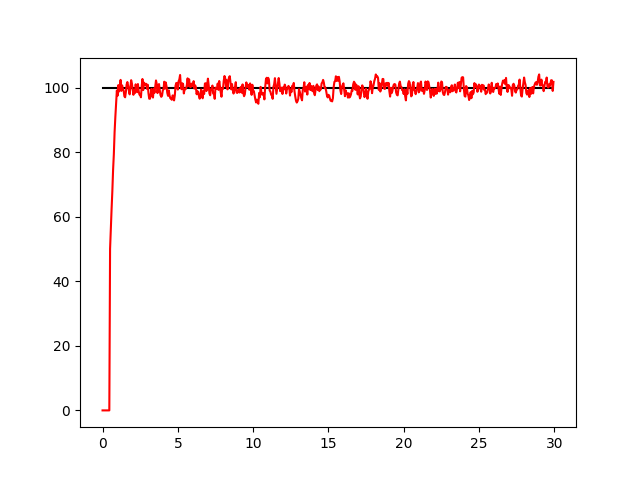

In [20]:
proc = Process(dt, acc_limit=100., noise=True)
v_set = np.zeros_like(x)
error = np.zeros_like(x)
cr = np.zeros_like(x)
ct = simple_pid.PID(Kp=.6, Ki=0.0, Kd=.0, sample_time=None)
for i in range(1, len(v_desired)):
    cr[i] = ct(error[i-1])
    set_pos = v_desired[i-1] + cr[i]
    set_pos_save = set_pos
    if v_desired[i-1] >= 50. and set_pos >= 0. and set_pos < 50.:
        set_pos = 50.
    if v_desired[i-1] <= -50. and set_pos <= 0. and set_pos > -50.:
        set_pos = -50
    #print("%.2f %.2f %.2f" % (set_pos_save, set_pos, v_desired[i-1]))
    v_set[i] = proc.update(set_pos)
    #print("%.2f %.2f%.2f" % (error[i-1], cr[i], v_set[i]))
    error[i] = v_desired[i] - v_set[i]
fig, ax = plt.subplots()
ax.plot(x, v_desired, 'k')
ax.plot(x, v_set, 'r')
#ax.plot(x, error, 'b')
#ax.plot(x, cr, 'g')